In [ ]:
!pip install ultralytics segment-anything pillow opencv-python-headless numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 17.8 MB/s eta 0:00:00


In [ ]:
import torch
import cv2
import numpy as np
from segment_anything import SamPredictor, sam_model_registry
from ultralytics import YOLO
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import os
import requests
from tqdm import tqdm

def download_sam_model(model_url, checkpoint_path):
    """
    Downloads the SAM model checkpoint if it doesn't already exist.

    Args:
        model_url (str): URL to the SAM checkpoint.
        checkpoint_path (str): Local path to save the checkpoint.
    """
    if not os.path.exists(checkpoint_path):
        print(f"Downloading SAM model from {model_url}...")
        response = requests.get(model_url, stream=True)
        total_size = int(response.headers.get("content-length", 0))
        with open(checkpoint_path, "wb") as file, tqdm(
            desc="Downloading SAM model",
            total=total_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                file.write(data)
                bar.update(len(data))
        print("Download complete.")
    else:
        print("SAM model already exists.")

# URL for the SAM ViT-H model
sam_model_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
sam_checkpoint = "sam_vit_h_4b8939.pth"

# Download the SAM model if not already present
download_sam_model(sam_model_url, sam_checkpoint)


Download complete.


In [ ]:
def generate_yolo_sam_mask(image_path, object_prompt, sam_checkpoint="sam_vit_h_4b8939.pth"):
    """
    Generates a mask for the specified object using YOLO for object detection and SAM for segmentation.
    """
    # Load YOLO model (pretrained on COCO dataset)
    yolo_model = YOLO("yolov8n.pt")

    # Load SAM model
    sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
    sam = sam.to("cuda" if torch.cuda.is_available() else "cpu")
    predictor = SamPredictor(sam)

    # Read the input image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = image.shape

    # Detect objects using YOLO
    results = yolo_model(image_rgb)
    detected_objects = []
    for detection in results[0].boxes:
        class_id = int(detection.cls[0].item())
        class_name = results[0].names[class_id]
        if object_prompt.lower() in class_name.lower():
            detected_objects.append(detection.xyxy[0].cpu().numpy())

    if not detected_objects:
        print(f"No object matching '{object_prompt}' was found.")
        return None

    # Use the first detected object's bounding box for mask generation
    bbox = detected_objects[0]
    x_min, y_min, x_max, y_max = map(int, bbox)

    print(f"Bounding box: ({x_min}, {y_min}, {x_max}, {y_max})")

    # Set the image in SAM
    predictor.set_image(image_rgb)

    # Generate a mask for the bounding box
    input_box = np.array([x_min, y_min, x_max, y_max])
    masks, _, _ = predictor.predict(
        box=input_box, multimask_output=False
    )

    # Convert the mask to a binary image
    mask = (masks[0] * 255).astype(np.uint8)

    # Save the mask
    mask_image = Image.fromarray(mask)
    mask_image.save("Masked_Image.png")
    print(f"Mask for '{object_prompt}' saved as 'Masked_Image.png'")
    return mask_image


Enter the object description (e.g., 'bicycle'): teddy bear

0: 640x640 1 person, 2 sports balls, 2 teddy bears, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Bounding box: (334, 237, 1187, 1222)
Mask for 'teddy bear' saved as 'Masked_Image.png'


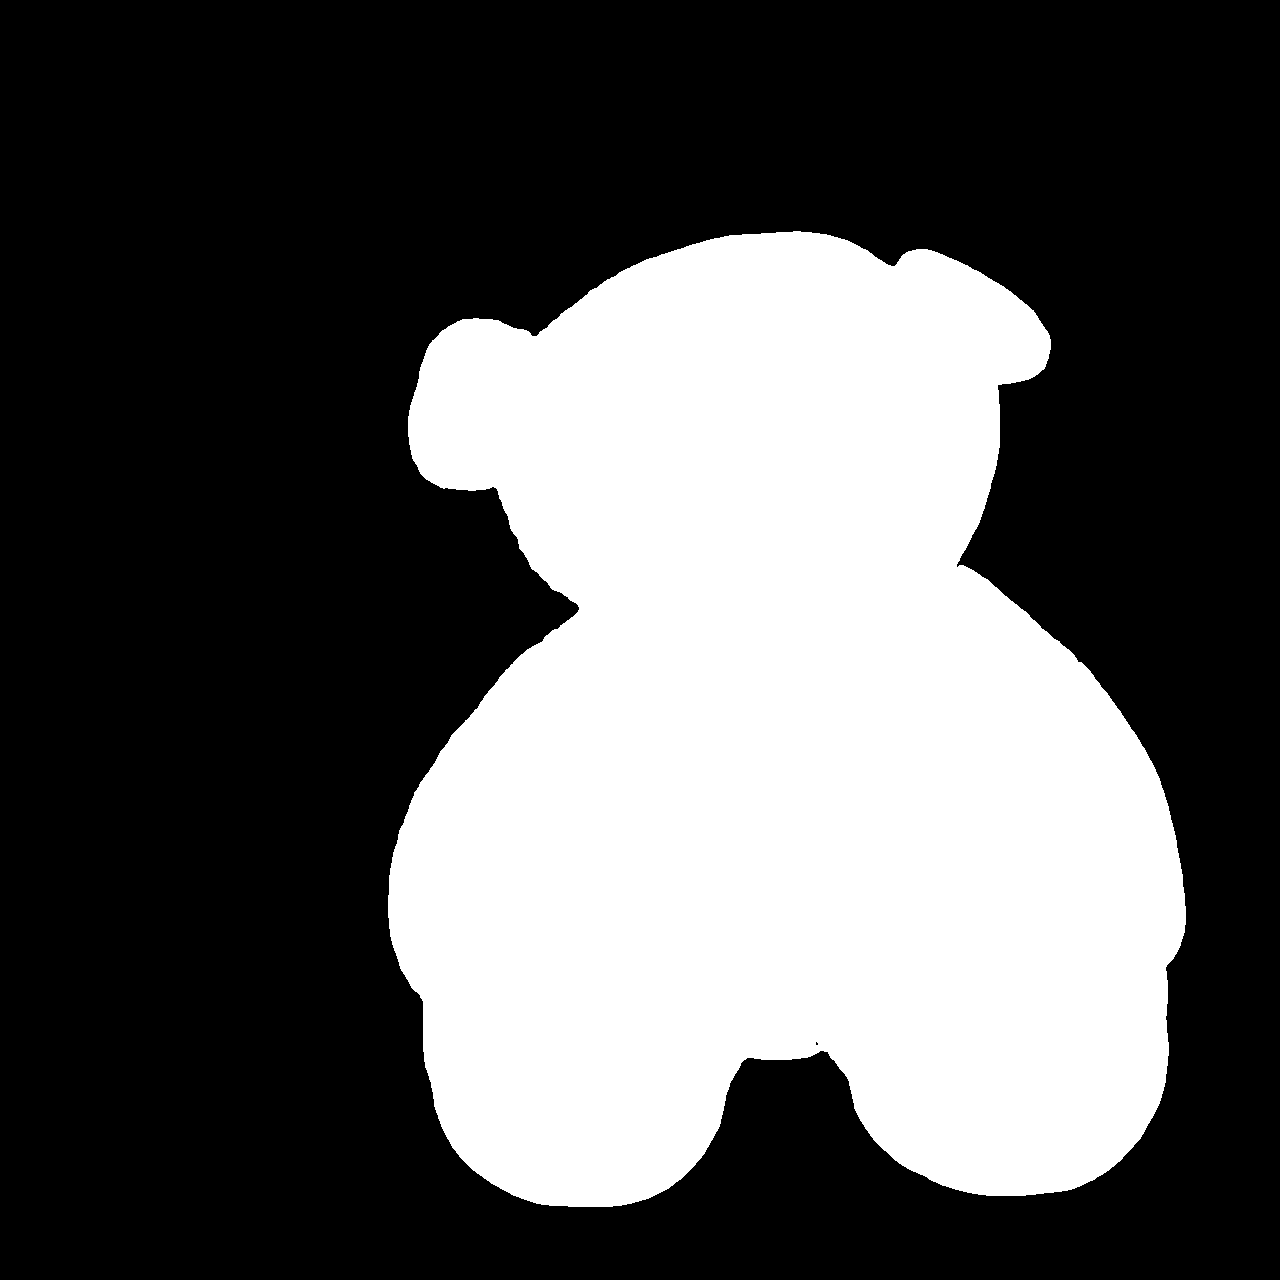

In [ ]:
# Define inputs
image_path = "/content/517250_Paw_stampT-shirt1__74295.jpg"  # Replace with your image path
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"  # Path to SAM checkpoint
object_prompt = input("Enter the object description (e.g., 'bicycle'): ")

# Generate the mask
generate_yolo_sam_mask(image_path, object_prompt, sam_checkpoint)
